In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg

from tqdm import tqdm

# Explicit Approach

In [4]:
class System:
    
    def __init__(self, EJ=121e9, EC=2.4e9, ng=0.5, flux=0, ncut=10):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = 1.60218e-19
        self.flux_quanta = self.h / (2 * self.e_charge)
        
        self.EJ = EJ * self.h                      # Josephson energy
        self.EC = EC * self.h                      # Josephson capacitance energy
        self.CJ = self.e_charge**2 / (4 * self.EC) # Josephson capacitance
        self.ng = ng                               # Reduced gate charge
        self.flux = flux * self.flux_quanta        # Flux through qubit
        self.ncut = ncut                           # Cut-off threshold for number basis
        
        self.init_operators()
    
    def init_operators(self):
        self.I_cb = np.diag(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        
        self.q_op_cb = np.diag(2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))               # Charge operator (charge basis)
        self.ng_op_cb = 2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = np.diag(np.ones(2 * self.ncut, dtype=np.complex_), k=1)                                       # e^{i \phi} operator (charge basis)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def kin_mat(self):
        self.init_operators()
        kin_mat = (2 * self.CJ)**-1 * (self.q_op_cb - self.ng_op_cb) @ (self.q_op_cb - self.ng_op_cb)

        return kin_mat

    def pot_mat(self):
        self.init_operators()
        pot_mat = -self.EJ * (self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_mat

    def get_H(self):
        self.H = self.kin_mat() + self.pot_mat()
        
        return self.H
    
    def diagonalise(self, update=False, N=1):
        if update:
            self.get_H()
        else:
            try:
                self.H
            except AttributeError:
                self.get_H()
        self.evals, self.evecs = sp.linalg.eigh(
            self.H, eigvals=(0, N), eigvals_only=False
        )
        self.evecs = self.evecs.T
        
        return self.evals, self.evecs
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise(update=True)
        else:
            try:
                self.evecs
            except AttributeError:
                self.diagonalise()

        self.qubit_0 = self.evecs[0]
        self.qubit_1 = self.evecs[1]
        self.qubit_m = 2**-0.5 * (self.qubit_0 - self.qubit_1)
        self.qubit_p = 2**-0.5 * (self.qubit_0 + self.qubit_1)

## Varying $\text{n}_\text{g}$

In [11]:
ngs = np.linspace(0, 1, 100)
E_0, E_1, E_2 = [], [], []

system = System(ncut=20, EJ=1, EC=2, ng=0.5)

evals, evecs = system.diagonalise(N=3, update=True)
E10 = evals[1] - evals[0]

for ng in tqdm(ngs):
    system.ng = ng
    
    evals, evecs = system.diagonalise(N=2, update=True)
    
    E_0.append(evals[0] / E10)
    E_1.append(evals[1] / E10)
    E_2.append(evals[2] / E10)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 358.61it/s]


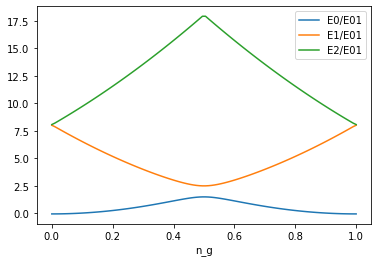

In [12]:
plt.plot(ngs, E_0, label='E0/E01')
plt.plot(ngs, E_1, label='E1/E01')
plt.plot(ngs, E_2, label='E2/E01')
plt.xlabel('n_g')
plt.legend()
plt.show()